In [69]:
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from xhistogram.xarray import histogram
import pandas as pd
import cartopy.crs as ccrs

u = 'https://thredds.met.no/thredds/dodsC/ww3_4km_archive_files/%Y/%m/%d/ww3_4km_%Y%m%dT00Z.nc'
url = datetime(2023, 1, 8).strftime(u)

print(url)

https://thredds.met.no/thredds/dodsC/ww3_4km_archive_files/2023/01/08/ww3_4km_20230108T00Z.nc


In [76]:
dr = pd.date_range(start='2023-01-01', end='2023-01-02')
td = dr[1] - dr[0]
urls = [d.strftime(u) for d in dr]
print(urls)
dss = [xr.open_mfdataset(ur).isel
print(ds)

['https://thredds.met.no/thredds/dodsC/ww3_4km_archive_files/2023/01/01/ww3_4km_20230101T00Z.nc', 'https://thredds.met.no/thredds/dodsC/ww3_4km_archive_files/2023/01/02/ww3_4km_20230102T00Z.nc']


ValueError: Resulting object does not have monotonic global indexes along dimension time

In [59]:
ds = xr.open_dataset(url)
print(ds)

<xarray.Dataset>
Dimensions:                  (rlat: 1026, rlon: 624, time: 73)
Coordinates:
  * rlat                     (rlat) float64 -14.35 -14.31 -14.27 ... 26.61 26.65
  * rlon                     (rlon) float64 5.53 5.57 5.61 ... 30.37 30.41 30.45
  * time                     (time) datetime64[ns] 2023-01-07T18:00:00 ... 20...
Data variables: (12/46)
    forecast_reference_time  datetime64[ns] ...
    rotated_pole             int8 ...
    longitude                (rlat, rlon) float32 ...
    latitude                 (rlat, rlon) float32 ...
    MAPSTA                   (rlat, rlon) int16 ...
    dpt                      (time, rlat, rlon) float32 ...
    ...                       ...
    utic                     (time, rlat, rlon) float32 ...
    vtic                     (time, rlat, rlon) float32 ...
    fic                      (time, rlat, rlon) float32 ...
    tp                       (time, rlat, rlon) float32 ...
    ff                       (time, rlat, rlon) float32 ...


In [60]:
ds = ds.isel({'time': slice(0, 2), 'rlat': slice(300, 620), 'rlon': slice(400, 630)})
wind_change = ds.ff.isel(time=1) - ds.ff.isel(time=0)
ds = ds.isel(time=0)
ds['wind_change'] = wind_change
print(ds)
wind_speed = ds.ff
print(wind_speed)

<xarray.Dataset>
Dimensions:                  (rlat: 320, rlon: 224)
Coordinates:
  * rlat                     (rlat) float64 -2.35 -2.31 -2.27 ... 10.37 10.41
  * rlon                     (rlon) float64 21.53 21.57 21.61 ... 30.41 30.45
    time                     datetime64[ns] 2023-01-07T18:00:00
Data variables: (12/47)
    forecast_reference_time  datetime64[ns] ...
    rotated_pole             int8 ...
    longitude                (rlat, rlon) float32 ...
    latitude                 (rlat, rlon) float32 ...
    MAPSTA                   (rlat, rlon) int16 ...
    dpt                      (rlat, rlon) float32 ...
    ...                       ...
    vtic                     (rlat, rlon) float32 ...
    fic                      (rlat, rlon) float32 ...
    tp                       (rlat, rlon) float32 ...
    ff                       (rlat, rlon) float32 ...
    dd                       (rlat, rlon) float32 ...
    wind_change              (rlat, rlon) float32 -0.4151 -0.3376 ... 

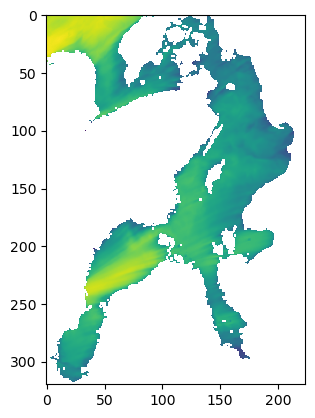

In [61]:
plt.imshow(wind_speed)
plt.show()

In [62]:
stokes = np.sqrt(ds.uuss**2 + ds.vuss**2)
print(stokes)

<xarray.DataArray (rlat: 320, rlon: 224)>
array([[0.24493313, 0.24531426, 0.24570382, ...,        nan,        nan,
               nan],
       [0.2451431 , 0.24545522, 0.24553147, ...,        nan,        nan,
               nan],
       [0.24532254, 0.24540858, 0.2454279 , ...,        nan,        nan,
               nan],
       ...,
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]], dtype=float32)
Coordinates:
  * rlat     (rlat) float64 -2.35 -2.31 -2.27 -2.23 ... 10.29 10.33 10.37 10.41
  * rlon     (rlon) float64 21.53 21.57 21.61 21.65 ... 30.33 30.37 30.41 30.45
    time     datetime64[ns] 2023-01-07T18:00:00


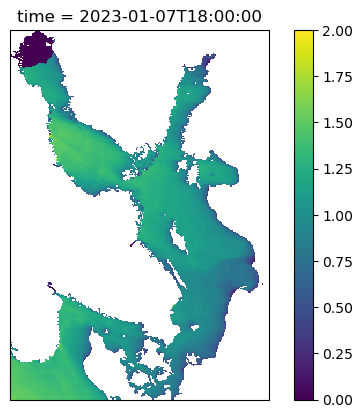

1.066154 1.021347


In [63]:
sr = stokes/wind_speed*100
sr.plot(vmin=0, vmax=2,
        subplot_kws={"projection": ccrs.Mercator()}, transform=ccrs.PlateCarree())
plt.show()
print(sr.median().values, sr.mean().values)

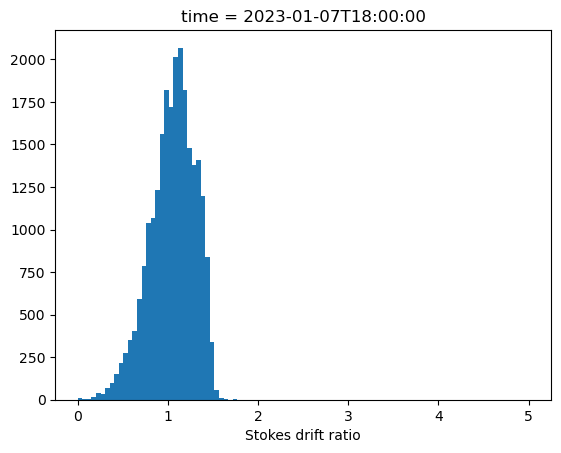

In [64]:
sr = sr.where(sr>0)
sr.name = 'Stokes drift ratio'
wind_speed = wind_speed.where(sr>0)
bins_w = np.linspace(0, 25, 100)
bins_s = np.linspace(0, 5, 100)

sr.plot.hist(bins=bins_s)
plt.show()

ff Stokes drift ratio


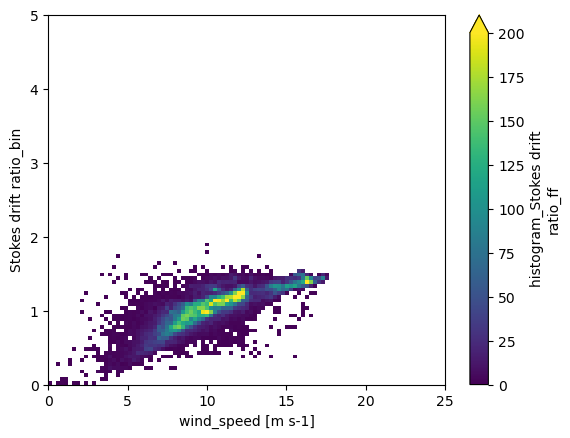

In [65]:
print(wind_speed.name, sr.name)
h = histogram(sr, wind_speed, bins=[bins_s, bins_w])
h.where(h>0).plot(vmin=0, vmax=200)

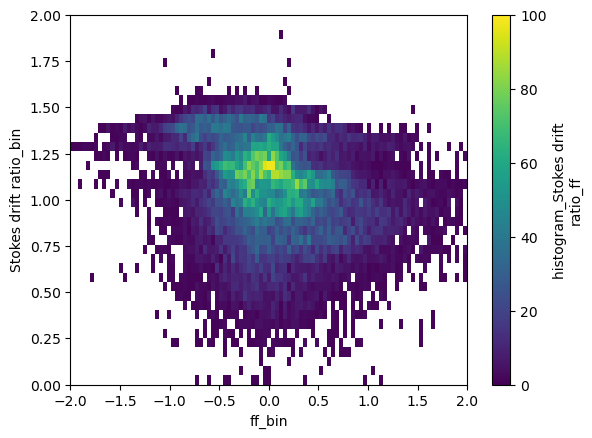

In [68]:
h = histogram(sr, wind_change, bins=[bins_s, np.linspace(-2, 2, 100)])
h.where(h>0).plot(vmin=0, vmax=100)
plt.ylim([0, 2])
plt.show()